In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field
import operator
import os

In [8]:
load_dotenv()

PERPLEXITY_API_KEY = os.getenv("PERPLEXITY_API_KEY")

model = ChatOpenAI(
    model="sonar",                     # base Sonar model
    base_url="https://api.perplexity.ai",
    api_key=PERPLEXITY_API_KEY,
    temperature=0.7
)

In [9]:
class schema(BaseModel):
    sentiment: Literal["Positive", 'Negative'] = Field(description= "Give the sentiment of the review ")

In [10]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')
    

In [11]:
structured_model= model.with_structured_output(schema)
structured_model2 = model.with_structured_output(DiagnosisSchema)


In [12]:
structured_model.invoke('Not good performance').sentiment

'Negative'

In [13]:
prompt = "I bought this software last week, and it keeps crashing every time I try to open a project. It's really frustrating! I need this fixed as soon as possible because I have important work pending."

In [14]:
structured_model2.invoke(prompt)

DiagnosisSchema(issue_type='Bug', tone='frustrated', urgency='high')

In [15]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [16]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [17]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

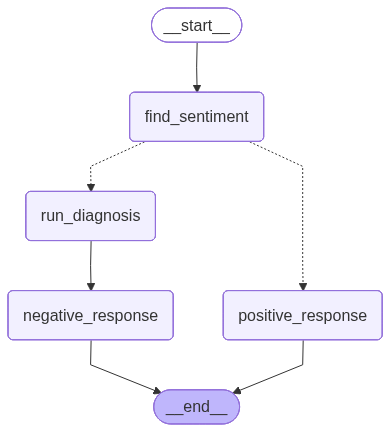

In [18]:
workflow


In [19]:

intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'Negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': 'I understand how frustrating this bug must be for you, especially given its urgency, and I sincerely apologize for the inconvenience it has caused. Please know that resolving this is my top priority, and I am here to help you get this fixed as quickly as possible. \n\nCould you please provide me with any additional details or error messages you’ve encountered? This will help me diagnose the issue more efficiently and offer you the best solution. Thank you for your patience—I’m committed to making this right for you promptly[2][3][5].'}